In [2]:
import torch
import torch.utils.data as data

import zuko
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
import sklearn.datasets as datasets


# Two moons

In [37]:
def two_moons(n: int, sigma: float = 1e-1):
    theta = 2 * torch.pi * torch.rand(n)
    label = (theta > torch.pi).float()

    x = torch.stack((
        torch.cos(theta) + label - 1 / 2,
        torch.sin(theta) + label / 2 - 1 / 4,
    ), axis=-1)

    return torch.normal(x, sigma), label

samples, labels = two_moons(16384)

In [4]:
#flow = zuko.flows.CNF(features=2, context=1, hidden_features=[32] )
flow = zuko.flows.NSF(features=2, context=1, transforms=3, hidden_features=(64, 64))
optimizer = torch.optim.Adam(flow.parameters(), lr=1e-4)
device = 'cpu'

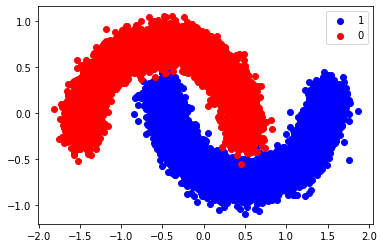

In [39]:
plt.figure(figsize=(6,4))

mask1 = labels>0
mask0 = labels<1
plt.scatter(samples[:,0][mask1],samples[:,1][mask1], label='1', color='b')
plt.scatter(samples[:,0][mask0],samples[:,1][mask0], label='0', color='r')
plt.legend()
plt.show()

In [40]:
trainset = data.TensorDataset(*two_moons(16384))
trainloader = data.DataLoader(trainset, batch_size=64, shuffle=True)

In [49]:
#flow = zuko.flows.NSF(features=2, context=1, transforms=3, hidden_features=(64, 64))
flow = zuko.flows.CNF(features=2, context=1, hidden_features=(64, 64))


In [50]:
optimizer = torch.optim.Adam(flow.parameters(), lr=1e-3)

for epoch in range(8):
    losses = []

    for x, label in trainloader:
        c = label.unsqueeze(dim=-1)

        loss = -flow(c).log_prob(x).mean()
        loss.backward()

        optimizer.step()
        optimizer.zero_grad()

        losses.append(loss.detach())

    losses = torch.stack(losses)

    print(f'({epoch})', losses.mean().item(), '±', losses.std().item())

(0) 1.4570567607879639 ± 0.24319477379322052
(1) 1.2002884149551392 ± 0.12570899724960327
(2) 0.86197829246521 ± 0.13498517870903015
(3) 0.5916064381599426 ± 0.12161406874656677
(4) 0.4802176356315613 ± 0.10986973345279694
(5) 0.436779260635376 ± 0.09914655983448029
(6) 0.40676793456077576 ± 0.10548562556505203
(7) 0.4056107699871063 ± 0.09944513440132141


In [51]:
flow.eval()

samples1_test = flow(torch.tensor([1])).sample((5000,))
samples0_test = flow(torch.tensor([0])).sample((5000,))

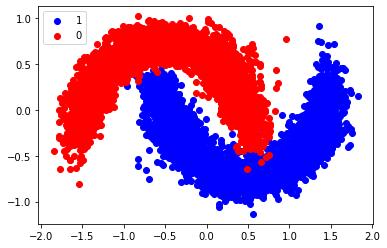

In [52]:


plt.figure(figsize=(6,4))


plt.scatter(samples1_test[:,0],samples1_test[:,1], label='1', color='b')
plt.scatter(samples0_test[:,0],samples0_test[:,1], label='0', color='r')
plt.legend()
plt.show()

# Blobs

In [4]:
data, labels = make_blobs(
    n_samples=10000,
    n_features=2,
    centers=4,
    cluster_std=[1.7, 5.0, 3.1, 0.2],
    random_state=314159,
)
classes = np.unique(labels)
print(f"Classes are: {classes}")

Classes are: [0 1 2 3]


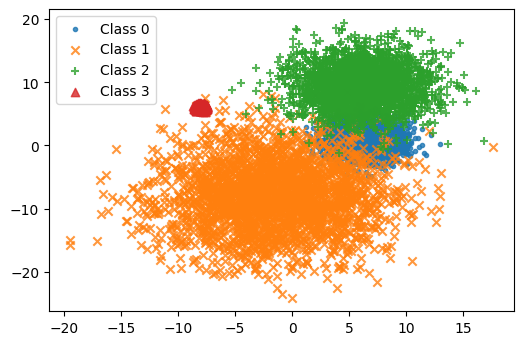

In [8]:
fig = plt.figure(dpi=100)
markers = [".", "x", "+", "^"]
for c, m in zip(classes, markers):
    idx = labels == c
    plt.scatter(
        data[idx, 0], data[idx, 1], label=f"Class {c}", marker=m, alpha=0.8
    )
plt.legend()
plt.show()

In [45]:
batch_size = 100
x_train, x_val, y_train, y_val = train_test_split(data, labels[:, np.newaxis])

In [46]:
x_train_tensor = torch.from_numpy(x_train.astype(np.float32))
y_train_tensor = torch.from_numpy(y_train.astype(np.float32))
train_dataset = torch.utils.data.TensorDataset(x_train_tensor, y_train_tensor)
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True
)

x_val_tensor = torch.from_numpy(x_val.astype(np.float32))
y_val_tensor = torch.from_numpy(y_val.astype(np.float32))
val_dataset = torch.utils.data.TensorDataset(x_val_tensor, y_val_tensor)
val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False
)

In [70]:
flow.train()

epochs = 200
loss = dict(train=[], val=[])

for i in range(epochs):
    flow.train()
    train_loss = 0.0
    for batch in train_loader:
        x, y = batch
        x = x.to(device)
        y = y.to(device)
        optimizer.zero_grad()
        _loss = -flow(y).log_prob(x).mean()
        _loss.backward()
        optimizer.step()
        train_loss += _loss.item()
    loss["train"].append(train_loss / len(train_loader))

    flow.eval()
    val_loss = 0.0
    for batch in val_loader:
        x, y = batch
        x = x.to(device)
        y = y.to(device)
        with torch.no_grad():
            _loss = -flow(y).log_prob(x).mean().item()
        val_loss += _loss
    loss["val"].append(val_loss / len(val_loader))
    if not i % 10:
        print(
            f"Epoch {i} - train: {loss['train'][-1]:.3f}, val: {loss['val'][-1]:.3f}"
        )

flow.eval()
print("Finished training")

Epoch 0 - train: 52.675, val: 52.594
Epoch 10 - train: 51.321, val: 51.393


KeyboardInterrupt: 

In [63]:
n = 10000
conditional = torch.from_numpy(
    np.random.choice(4, size=(n, 1)).astype(np.float32)
).to(device)
with torch.no_grad():
    samples = flow(conditional).sample((1,))
samples = samples.cpu().squeeze(0).numpy()
conditional = conditional.cpu().numpy()

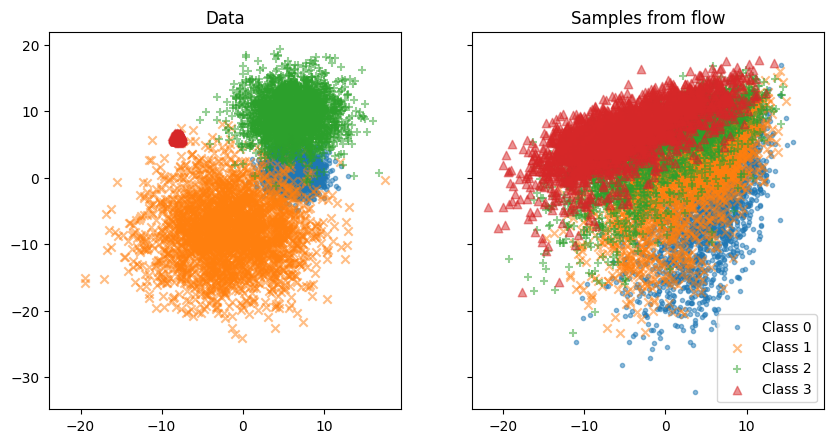

In [64]:
fig, ax = plt.subplots(
    1, 2, sharex=True, sharey=True, figsize=(10, 5), dpi=100
)
markers = [".", "x", "+", "^"]
for c, m in zip(classes, markers):
    idx = labels == c
    ax[0].scatter(
        data[idx, 0], data[idx, 1], label=f"Class {c}", marker=m, alpha=0.5
    )

    idx = conditional[:, 0] == c
    ax[1].scatter(
        samples[idx, 0],
        samples[idx, 1],
        label=f"Class {c}",
        marker=m,
        alpha=0.5,
    )
ax[0].set_title("Data")
ax[1].set_title("Samples from flow")
plt.legend()
plt.show()